In [1]:
import openeo
from openeo.processes import *
import geopandas as gpd

In [45]:
# connect to the openEO service
conn = openeo.connect("openeo.cloud").authenticate_oidc()


Authenticated using refresh token.


In [ ]:
# describe the GFM collection
conn.describe_collection("GFM")

In [47]:
# set parameters
# extract spatial extent from aoi shapefile
bbox = gpd.read_file(r"Data\Data\baringo_bbox\baringo_bbox.shp").total_bounds
spatial_extent = {
    "west": bbox[0],
    "south": bbox[1],
    "east": bbox[2],
    "north": bbox[3]}

# temporal extent from 2018-2025
temporal_extent = ["2018-02-01", "2018-03-01"]  #example 1 month


# define which collection to use
collection = "GFM"

# load the collection with the specified spatial and temporal extents
gfm_data = conn.load_collection(
    collection, 
    spatial_extent=spatial_extent, 
    temporal_extent=temporal_extent, 
    bands = ["ensemble_flood_extent"]
)

# apply a reducer to sum the flood extent over time
gfm_sum = gfm_data.reduce_dimension(dimension="t", reducer=sum)

# save the result as a GeoTIFF file with a specified tile grid
gfm_sum_tiff = gfm_sum.save_result(format="GTiff", options={"tile_grid": "wgs84-1degree"})


In [48]:
# create and start a job to execute the process
job = gfm_sum_tiff.create_job(title = "flood_extent").start_job()

OpenEoApiError: [500] Internal: Failed to create job on backend 'eodc': OpenEoApiError('[500] Internal Error: (psycopg2.OperationalError) connection to server at "10.152.183.184", port 5432 failed: FATAL:  remaining connection slots are reserved for non-replication superuser connections\n\n(Background on this error at: https://sqlalche.me/e/20/e3q8)') (ref: r-25070212394047479868f66674aedc2e)

In [10]:
# wait for the job to finish
job.status()

OpenEoApiError: [500] Internal Error: (psycopg2.OperationalError) connection to server at "10.152.183.184", port 5432 failed: FATAL:  remaining connection slots are reserved for non-replication superuser connections

(Background on this error at: https://sqlalche.me/e/20/e3q8) (ref: r-2507021214224c708ad2ccaf7d2e801c)

In [ ]:
# download the results
job.get_results().download_files("./gfm1/flood_extent_wgs/")

OpenEoApiError: [500] Internal Error: (psycopg2.OperationalError) connection to server at "10.152.183.184", port 5432 failed: FATAL:  remaining connection slots are reserved for non-replication superuser connections

(Background on this error at: https://sqlalche.me/e/20/e3q8) (ref: r-2507021141534431bca6394b696907ad)

TESTING FOR ALL MONTHS

In [ ]:
from datetime import datetime, timedelta
import os
import time
from dateutil.relativedelta import relativedelta


In [ ]:
# Define start and end date
start_date = datetime(2018, 1, 1)
end_date = datetime(2025, 6, 30)  # To date

# Folder to save results
output_folder = "./gfm/flood_extent_wgs/"
os.makedirs(output_folder, exist_ok=True)

current_date = start_date
jobs = [] #list tos store the created jobs

# Create and start all jobs
while current_date <= end_date:
    period_start = current_date
    period_end = current_date + relativedelta(months=3) - timedelta(days=1)
    
    if period_end > end_date:
        period_end = end_date
    
    temporal_extent = [period_start.strftime("%Y-%m-%d"), period_end.strftime("%Y-%m-%d")]
    print(f"Creating job for {temporal_extent[0]} to {temporal_extent[1]}")

    gfm_dataset = conn.load_collection(
        collection,
        spatial_extent=spatial_extent,
        temporal_extent=temporal_extent,
        bands=["ensemble_flood_extent"]
    )

    gfm_sum = gfm_dataset.reduce_dimension(dimension="t", reducer=sum)
    gfm_sum_tiff = gfm_sum.save_result(format="GTiff", options={"tile_grid": "wgs84-1degree"})

    job = gfm_sum_tiff.create_job(title="flood_extent")
    job.start_job()

    jobs.append((period_start.strftime('%Y_%m'), job))
    
    current_date = period_end + timedelta(days=1)

In [ ]:
job.status()

In [ ]:
for month, job in jobs:
    print(f"Downloading results for {month}...")
    job.get_results().download_files(os.path.join(output_folder, month))

visualize the data

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray

In [29]:
path = "./gfm_fin/flood_extent_wgs/WGS84_E35N0_20180102T155529.tif"
flood_extent = rioxarray.open_rasterio(path)
print(flood_extent)

<xarray.DataArray (band: 1, y: 4574, x: 2517)> Size: 46MB
[11512758 values with dtype=float32]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 20kB 35.55 35.55 35.55 35.55 ... 36.0 36.0 36.0
  * y            (y) float64 37kB 0.9219 0.9217 0.9215 ... 0.09891 0.09873
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:                 Area
    filepaths:                     []
    gfm:                           https://extwiki.eodc.eu/GFM
    long_name:                     reproject-7d43cc36effc47c28ae7be7d09e73b36
    snapshot_STAC_collection_URL:  https://stac.eodc.eu/api/v1/collections/GFM
    _FillValue:                    -9999.0
    scale_factor:                  1.0
    add_offset:                    0.0


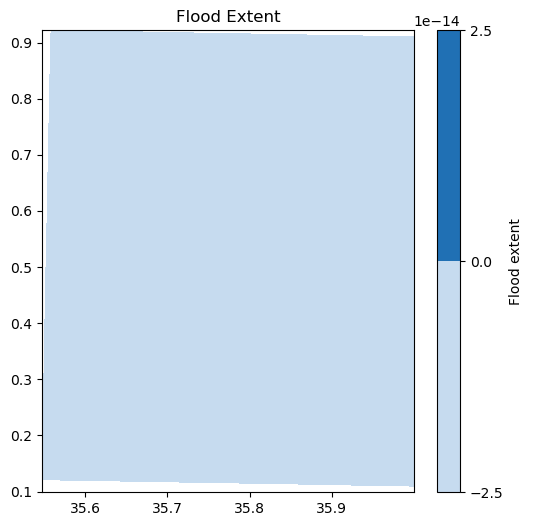

In [40]:
# Extract flood band and clean no-data values
flood_extent_clean = flood_extent.sel(band=1)
flood_extent_clean = flood_extent_clean.where(flood_extent_clean != -9999)


# Meshgrid for plotting
X, Y = np.meshgrid(flood_extent_clean.x.values, flood_extent_clean.y.values)

# Plot
plt.figure(figsize=(6,6))
plt.title("Flood Extent", fontsize=12)
f = plt.contourf(X, Y, flood_extent_clean, cmap='Blues')
plt.colorbar(label="Flood extent")  
plt.show()